# NUS Datathon Champion Team 291

# 1 Loading data


In [34]:
import pandas as pd
df0 = pd.read_csv('catA_train.csv')

In [41]:
df0.info()

In [42]:
df0.isna().sum()

In [ ]:
df0 = df0.dropna(subset=["LATITUDE", "LONGITUDE", "Year Found", "Employees (Domestic Ultimate Total)", "Employees (Global Ultimate Total)"])

#One-Hot Encoding
df0 = pd.get_dummies(df0, columns=['Entity Type'], prefix='Entity_Type')
df0 = pd.get_dummies(df0, columns=['Ownership Type'], prefix='Ownership_Type')
df0 = pd.get_dummies(df0, columns=['Import/Export Status'], prefix='Import_Export_Status')

# Dropping unimportant columns
df = df0.drop(['Fiscal Year End', 'Square Footage', 'Company Status (Active/Inactive)', 'Employees (Single Site)'], axis=1)

In [ ]:
df.isna().sum()

In [ ]:
sic_code_frequency = df['SIC Code'].value_counts()

# Set a threshold for low-frequency SIC Codes
threshold = 7  # Adjust this threshold based on your preference

# Identify SIC Codes with frequency below the threshold
low_frequency_sic_codes = sic_code_frequency[sic_code_frequency < threshold].index

# Replace these low-frequency SIC Codes with a common label "Others"
df['SIC Code'] = df['SIC Code'].replace(low_frequency_sic_codes, 'Others')

sic_code_frequency1 = df['SIC Code'].value_counts()

# Display the updated DataFrame
print(sic_code_frequency1)

In [ ]:
# Convert the entire column to a common data type (string in this case)

df['SIC Code'] = df['SIC Code'].astype(str)

# 2 EDA

We will now proceed to analyze and visualize a subset of our data to gain some rough insight into how inputs in our data are related to our outputs.

In [ ]:
# use of a correlation matrix to observe how variables in our dataset may be affected by others
numerical_df = df.select_dtypes(include=['float64', 'int64'])

# Create a correlation matrix
correlation_matrix = numerical_df.corr()

# Assuming correlation_matrix is your correlation matrix
correlation_df = pd.DataFrame(correlation_matrix)

# Print or use the correlation DataFrame as needed
correlation_df

### Geospatial Analysis

In [ ]:
# import required libraries
import matplotlib.pyplot as plt

# we will need this for the color gradient representing how high the domestic sales figure is.
from matplotlib.colors import LogNorm
import seaborn as sns

# read in the ENTIRE dataset and do EDA. confusion matrix, etc
# Use LogNorm for more sensitivity to numerical changes
norm = LogNorm()

# Define a constant color (e.g., blue)
constant_color = 'purple'

# Define a color palette based on unique industries
industry_palette = sns.color_palette('Set1', n_colors=len(df['Industry'].unique()))

# Create a dictionary to map Industry to a unique color
industry_colors = dict(zip(df['Industry'].unique(), industry_palette))

# Scatter plot with varying color by Industry and varying alpha based on Sales values
scatter = plt.scatter(df['LONGITUDE'], df['LATITUDE'], c=df['Industry'].map(industry_colors), s=3, alpha=norm(df['Sales (Domestic Ultimate Total USD)']))

# Add a legend for Industry
legend_labels = df['Industry'].unique()
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=industry,
                              markerfacecolor=industry_colors[industry], markersize=4) for industry in legend_labels]
plt.legend(handles=legend_handles, title='Industry', prop={'size': 5}, loc='upper left', bbox_to_anchor=(1, 1))

# Set labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot with Varying Color by Industry and Varying Alpha Based on Sales (LogNorm)')

# Show the plot
plt.show()

In [ ]:
# Use LogNorm for more sensitivity to numerical changes
norm = LogNorm()

# Define a colormap transitioning from blue to red
cmap = 'inferno'

# Scatter plot with colors based on Sales values and LogNorm
scatter = plt.scatter(df['LONGITUDE'], df['LATITUDE'], c=df['Sales (Domestic Ultimate Total USD)'], cmap=cmap, s=5, norm=norm)

# Add a colorbar
cbar = plt.colorbar(scatter, label='Sales')

# Set labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot with Colors Based on Sales (LogNorm)')

# Show the plot
plt.show()

## 2.2 Feature Selection
We will remove features that are of the following:
- seemingly irrelevant to affecting the output by domain knowledge;
- Low/Zero-variance Factors.

We will also filter our dataset to select only the rows of data we are interested in.

In [ ]:
# Specify columns to drop
columns_to_drop = ["Global Ultimate Company", "Domestic Ultimate Company", "Company Description", "8-Digit SIC Code", "8-Digit SIC Description", "AccountID",
                   "Parent Company", "City", "Country", "Industry", "Region", "Parent Country", "Global Ultimate Country", "Company"]

# Drop columns if they exist in the DataFrame
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

In [ ]:
# Convert 'Is Domestic Ultimate' to True/False
df['Is Domestic Ultimate'] = df['Is Domestic Ultimate'] == 1
df['Is Global Ultimate'] = df['Is Global Ultimate'] == 1

df.head(2)

In [ ]:
print(df.describe())

### Data Type Conversion

We will need to convert some columns into datatypes that are suitable for analysis. This makes sure that the values in these fields make sense.

In [ ]:
df = df.rename(columns={'Employees (Domestic Ultimate Total)': 'Employees_domesticUltimateTotal', 'Employees (Global Ultimate Total)': 'Employees_globalUltimateTotal', 'Sales (Domestic Ultimate Total USD)': 'Sales_domesticUltimateTotalUSD', 'Sales (Global Ultimate Total USD)': 'Sales_globalUltimateTotalUSD', 'SIC Code':'SIC_code', 'Year Found':'year_found'})

# 3 Model Training and Evaluation

## 3.1 Selecting a Model

In [ ]:
# ML Time
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import GradientBoostingRegressor

# Separate features and target variable
X = df.drop('Sales_domesticUltimateTotalUSD', axis=1)
y = df['Sales_domesticUltimateTotalUSD']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, df['Sales_domesticUltimateTotalUSD'], test_size=0.2, random_state=42)

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
le = preprocessing.LabelEncoder()
enc = OneHotEncoder(handle_unknown='ignore')

X_train2 = enc.fit_transform(X_train)
X_test2 = enc.fit_transform(X_test)
y_train2 = le.fit_transform(y_train)
y_test2 = le.fit_transform(y_test)

#y_train3 = y_train2.reshape(-1, 1)

# Initialize the GradientBoostingRegressor
model = GradientBoostingRegressor(random_state=42)

### Cross-Validation

We will also perform a K-fold Cross Validation. This helps us mitigate the risk of overfitting on a specific set of data, by being able to split the data into K number of folds, test on 1 fold and train for the rest for K number of times.

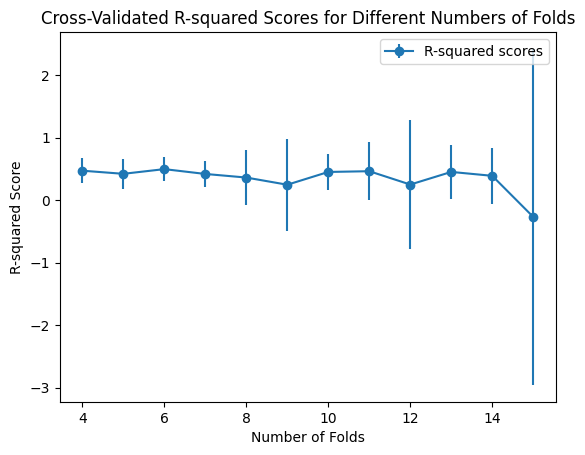

In [61]:
# Lists to store results
n_folds_values = list(range(4, 16))
mean_r2_scores = []
std_r2_scores = []

from tqdm import tqdm

# Iterate over different numbers of folds
for n_folds in tqdm(n_folds_values):
    # Use k-fold cross-validation with the current number of folds
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    # Perform cross-validation and get R-squared scores
    cv_scores = cross_val_score(model, X_train2, y_train2, cv=kf, scoring='r2')

    # Append mean and standard deviation of R-squared scores to lists
    mean_r2_scores.append(cv_scores.mean())
    std_r2_scores.append(cv_scores.std())

# Plot the results
plt.errorbar(n_folds_values, mean_r2_scores, yerr=std_r2_scores, marker='o', linestyle='-', label='R-squared scores')
plt.xlabel('Number of Folds')
plt.ylabel('R-squared Score')
plt.title('Cross-Validated R-squared Scores for Different Numbers of Folds')
plt.legend()
plt.show()

## 3.2 Model Evalutation Metrics

There are many ways to evaluate a Machine Learning model:

- Residual Mean Squared Error (RMSE), Mean Squared Error (MSE), Mean Average Percentage Error (MAPE) for Regression Tasks;
- Confusion Matrix, AUC-ROC Curve for Classification Problems;
- and other variants of such metrics.

In this problem, MSE will be very big as the sales are very large by nature. We will opt to use the R-Squared Score (used to score how well a regression model fits its data).

In [ ]:
# Use k-fold cross-validation with 10 folds
model_10 = GradientBoostingRegressor(random_state=42)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation and get R-squared scores
cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')

# Print the R-squared scores for each fold
print("Cross-Validation R-squared scores:", cv_scores)

# Print the mean and standard deviation of the R-squared scores
print("Mean R-squared score:", cv_scores.mean())
print("Standard Deviation of R-squared scores:", cv_scores.std())

# Train the model on the entire training set
model_10.fit(X_train, y_train)

# Evaluate the model on the test set
test_score = model_10.score(X_test, y_test)
print("Test R-squared score:", test_score)

# The cell below is NOT to be removed
The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list).
It is recommended to test the function out prior to submission
The hidden_data parsed into the function below will have the same layout columns wise as the dataset SENT to you
Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [ ]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform. 
    
All relevant code MUST be included in this function.'''

    result = [] 
    return result

In [ ]:
# This cell should output a list of predictions.
test_df = pd.read_csv(filepath)
test_df = test_df.drop(columns=['Sales (Domestic Ultimate Total USD)'])
print(testing_hidden_data(test_df))